# Business desicions

## Project description

As an analyst for a large online store, you and the marketing department have prepared a list of hypotheses for increasing revenue.
You need to prioritize the hypotheses using the ICE and RICE frameworks, run an A/B test, and analyze its results (metrics studied in the project: cumulative revenue, average check, conversion to orders).

## Описание данных

* Данные для первой части

Файл `/datasets/hypothesis.csv`
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


* Данные для второй части

Файл `/datasets/orders.csv`
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
# импортируем библиотеки, необходимые для работы
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# код для отображения всего текста в колонках
pd.set_option('display.max_colwidth', None)  # устанавливаем максимальную ширину колонок
pd.set_option('display.expand_frame_repr', False)  # без переноса текста на новую строчку

In [3]:
# загрузим датасеты

try:
    hypothesis, orders, visitors = (
    pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),  # данные по гипотезам
    pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),  # данные о заказах
    pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv'),  # данные о пользователях
    )
    
except:
    hypothesis, orders, visitors = (
    pd.read_csv('datasets/hypothesis.csv'),  # данные по гипотезам
    pd.read_csv('datasets/orders.csv'),  # данные о заказах
    pd.read_csv('datasets/visitors.csv'),  # данные о пользователях
    )  
    
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [4]:
#Изучим общую информацию о датафреймах    
def print_info_and_sample(df):
    df.info()
    print('*'*50)
    display(df.sample(5, random_state=1))
    
#print_info_and_sample(hypothesis)
hypothesis.info()
display(hypothesis)
print_info_and_sample(orders)
print_info_and_sample(visitors)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
**************************************************


,transactionId,visitorId,date,revenue,group
886,51443164,4278982564,2019-08-05,24744,A
1093,3894437543,276558944,2019-08-12,5050,A
801,504373597,2604012846,2019-08-05,890,B
189,4189935502,1648269707,2019-08-17,290,B
808,2344401705,366673373,2019-08-05,1460,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
**************************************************


,date,group,visitors
21,2019-08-22,A,609
52,2019-08-22,B,650
38,2019-08-08,B,654
24,2019-08-25,A,621
2,2019-08-03,A,507


In [5]:
# проверим датафреймы на явные дубликаты
def count_duplicates(df, name):
    duplicates = df.duplicated(keep='first').sum()
    print(f'Количество явных дубликатов в {name} до удаления: {duplicates}')

count_duplicates(hypothesis, 'Hypothesis')
count_duplicates(orders, 'transactionId')
count_duplicates(visitors, ['date', 'group'])

Количество явных дубликатов в Hypothesis до удаления: 0
Количество явных дубликатов в transactionId до удаления: 0
Количество явных дубликатов в ['date', 'group'] до удаления: 0


- В представленных датафреймах нет пропусков и нет явных дубликатов, колонки имеют корректный тип данных
- Однако названия колонок в датафреймах нужно привести к общеупотребимому стилю

In [6]:
#переименуем колонки
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()
visitors.columns = [x.lower().replace(' ', '_') for x in visitors.columns]


#проверим, что преобразования прошли корректно    
print_info_and_sample(hypothesis)
print_info_and_sample(orders)
print_info_and_sample(visitors) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
**************************************************


/var/folders/ks/347k6l591c7dymd3zn2l2fy80000gn/T/ipykernel_6350/1863012401.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  orders.columns = orders.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()


,hypothesis,reach,impact,confidence,efforts
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
**************************************************


,transaction_id,visitor_id,date,revenue,group
886,51443164,4278982564,2019-08-05,24744,A
1093,3894437543,276558944,2019-08-12,5050,A
801,504373597,2604012846,2019-08-05,890,B
189,4189935502,1648269707,2019-08-17,290,B
808,2344401705,366673373,2019-08-05,1460,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
**************************************************


,date,group,visitors
21,2019-08-22,A,609
52,2019-08-22,B,650
38,2019-08-08,B,654
24,2019-08-25,A,621
2,2019-08-03,A,507


- Преобразования прошли корректно. Колонки имеют ожидаемый тип данных и имена

## Часть 1. Приоритизация гипотез.

В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Затем применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
Рассмотрим, как изменилась приоритизация гипотез при применении RICE вместо ICE и прокомментируем почему так произошло

In [7]:
# приоритизация по фреймворку ICE
hypothesis['ice'] = round(
    hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
)

display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)) 

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0


In [8]:
hypothesis['rice'] = round(
    hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
)

display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Исходя из фреймворка ICE, приоритет отдается гипотезе "Запустить акцию, дающую скидку на товар в день рождения" (гипотеза 8), однако при расчете по методу RICE эта же гипотеза занимает только 5 место, уступая "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (гипотеза 7). Это связано с низкой оценкой Reach = 1 (скольких пользователей затронет изменение, которое мы хотитм внести) у гипотезы 8 в то время как у гипотезы 7 этот показатель равен 10. Стоимость тестирования этих двух гипоез при этом одинакова и равна 5.  
В четверку лидеров вошли также гипотезы "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию".

## Часть 2. Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах `/datasets/orders.csv` и `/datasets/visitors.csv`. Необходимо проанализировать A/B-тест.

### 1. График кумулятивной выручки по группам

In [9]:
display(orders.head())
display(visitors.head())

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 
      'group' : 'max', 
      'transaction_id' : 'nunique', 
      'visitor_id' : 'nunique', 
      'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 
          'group' : 'max', 
          'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


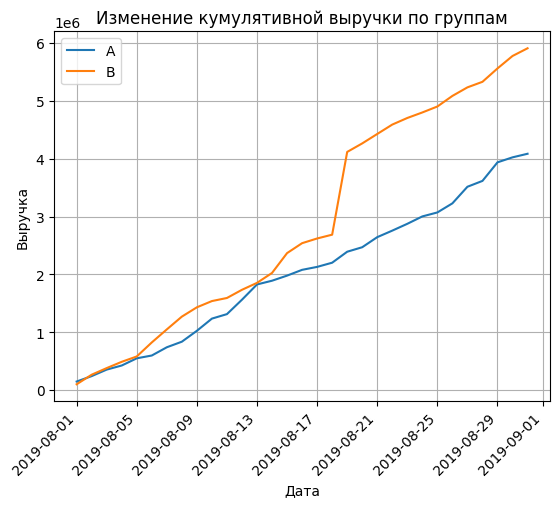

In [11]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('Изменение кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.xticks(rotation=45, ha='right') # Поворот на 45 градусов значений по х оси
plt.legend()
plt.show();

Выручка почти равномерно увеличивается в течение всего теста.
Однако график выручки в группе В резко растет после 17 августа 2019. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке группы В.

### 2. График кумулятивного среднего чека по группам— разделим кумулятивную выручку на кумулятивное число заказов

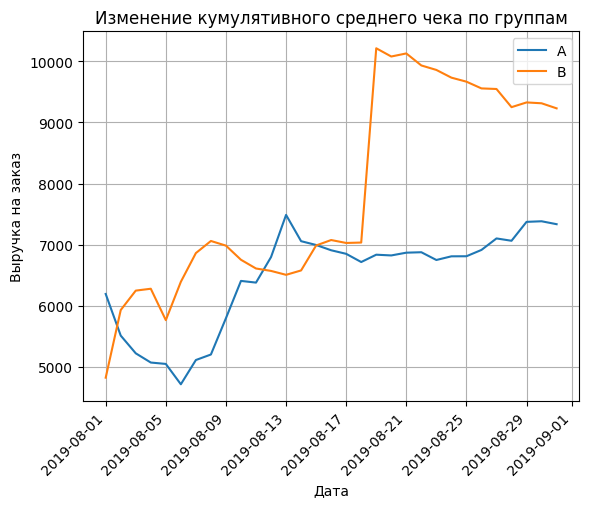

In [12]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.title('Изменение кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка на заказ')
plt.grid(True)
plt.xticks(rotation=45, ha='right') # Поворот на 45 градусов значений по х оси
plt.legend()
plt.show();

Средний чек только начинает выравниваться ближе к концу теста: установился для группы A и продолжает падать для группы B. Судя по всему в группу B после 17 августа 2019 попали крупные заказы (резкий всплеск на графике). Группе В нужно больше времени, чтобы прийти к реальному среднему чеку и установиться на его уровне.

### 3. График относительного изменения кумулятивного среднего чека группы B к группе A

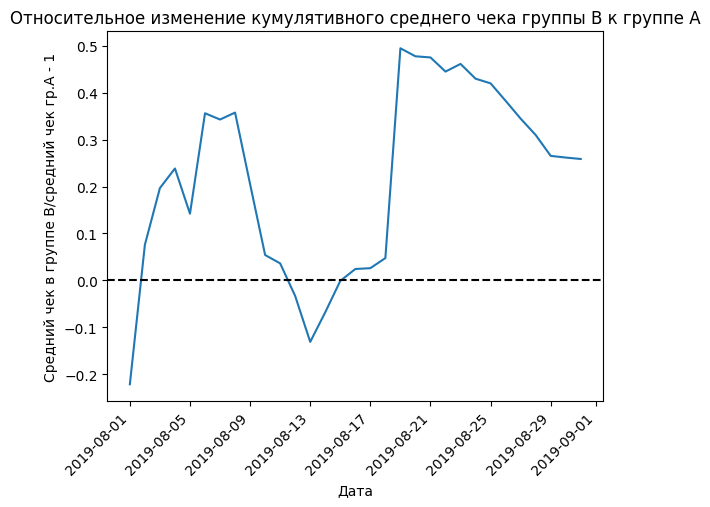

In [13]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

# cтроим отношение средних чеков
plt.plot(
    merged_cumulative_revenue['date'], 
    (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Средний чек в группе В/средний чек гр.А - 1')
plt.xticks(rotation=45, ha='right') # Поворот на 45 градусов значений по х оси
plt.show();

В нескольких точках график различия между сегментами резко «скачет» (между 8 и 19 августа 2019). Необходимо изучить присутствие в выборках крупных заказов и выбросов.

## 4. График кумулятивного среднего количества заказов на посетителя по группам 

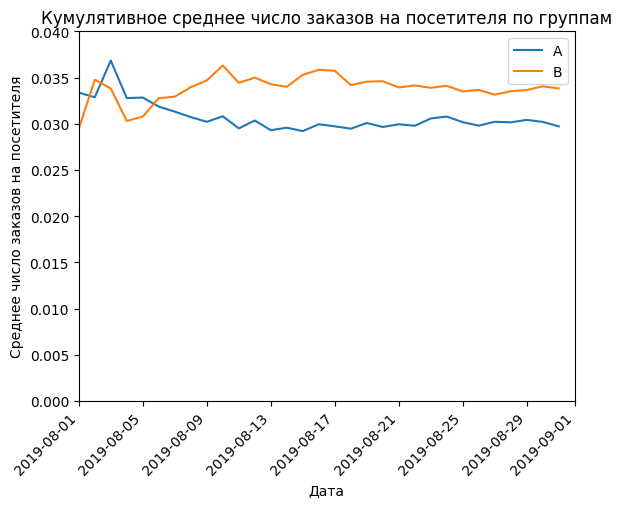

In [14]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.title('Кумулятивное среднее число заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее число заказов на посетителя')
plt.xticks(rotation=45, ha='right') # Поворот на 45 градусов значений по х оси
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.04])
plt.show();

В первые пять дней теста группы вели себя похожим образом, однако затем в группе В среднее число заказов стало превалировать над группой А, такое поведение сохранилось до конца теста. Это может быть результатом влияния выбросов или особоенно крупных заказов, как было отмечено выше.

### 5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

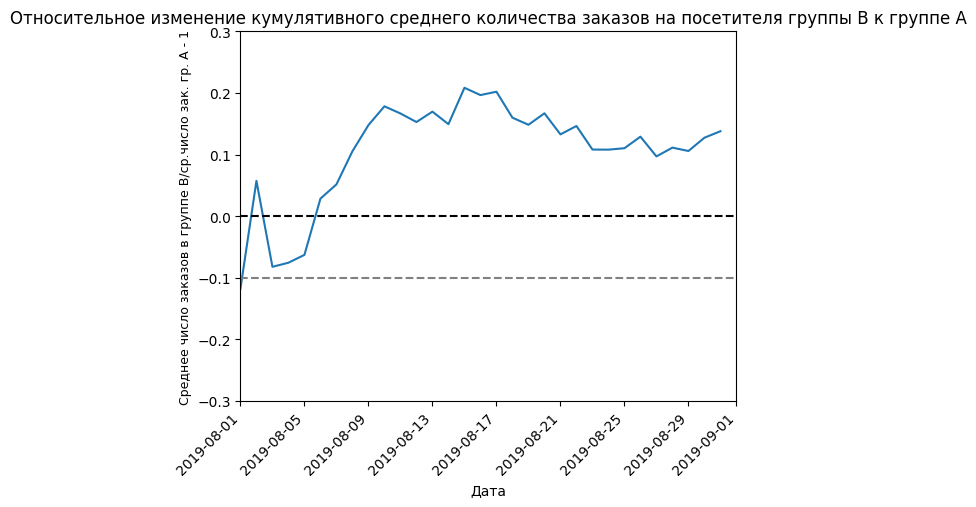

In [15]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
    cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

plt.plot(
    merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1,\
    label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")

plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Среднее число заказов в группе В/ср.число зак. гр. А - 1', fontsize=9)
plt.xticks(rotation=45, ha='right') # Поворот на 45 градусов значений по х оси
#plt.legend(loc='upper center', bbox_to_anchor=(1, 0.15), fancybox=True, shadow=True, ncol=1)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.3, 0.3]) # задаем масштаб осей


plt.show();

В начале теста (со 2-го августа) группа B проигрывала группе A, затем (6 августа) стала лидировать. Потом среднее количество заказов на посетителя для группы B росло, а к концу стало несколько снижаться.

Для более корректных выводов по тесту необходимо изучить данные на выбросы или аномальные значения

### 6. График количества заказов по пользователям

In [16]:
display(orders.head(10))

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [17]:
# выведем таблицу по числу заказов на пользователя
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['visitor_id', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False).head(10))

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


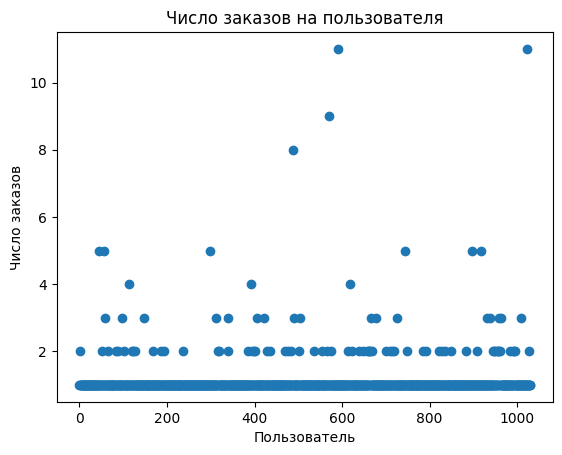

In [18]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])
plt.title('Число заказов на пользователя')
plt.xlabel('Пользователь')
plt.ylabel('Число заказов')
plt.show();

Довольно много пользователей с 1-2 заказами, встречаются также те, кто заказывал 3 и более раз, но реже. Чтобы определеить число заказов у 1 и 5% пользователей, посчитаем перцентили.

### 7. 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей

In [19]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли больше 2 заказов. И 1% пользователей заказывали более четырех раз. 
Выберем 3 заказа на одного пользователя за верхнюю границу числа заказов, чтобы отсеять аномальных пользователей по ней. 

### 8. График стоимостей заказов

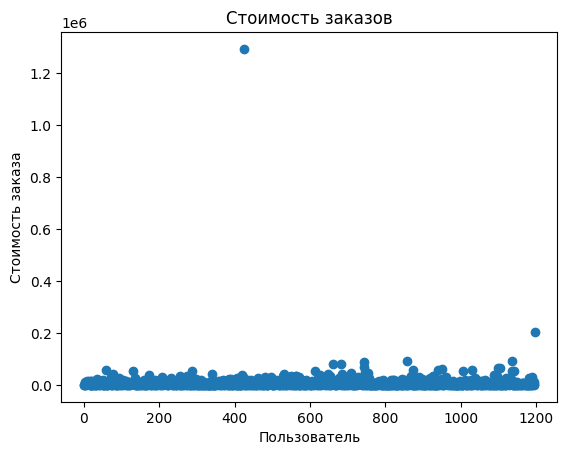

In [20]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказа')
plt.show();

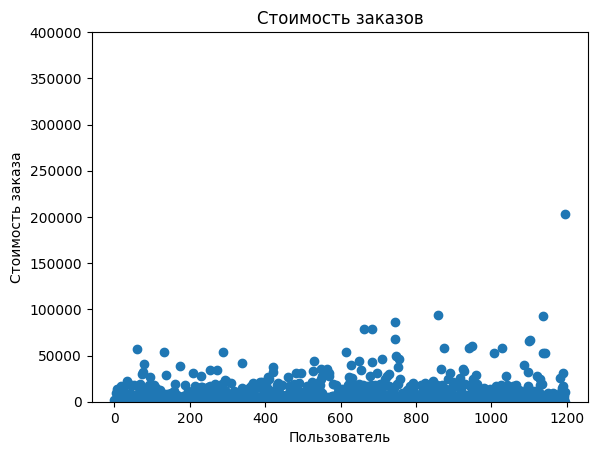

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 400000) #строка, чтобы изучить данные в другом диапазоне 
plt.title('Стоимость заказов')
plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказа')
plt.show();

Судя по графику, есть немного дорогих заказов или выбросов. Однако при рассмотрении того же графика в диапазоне до 400000 р (ось у) можно увидеть другие выбивающиеся значения, установить лимит аномальной стоимости заказа лучше с помощью перцентилей.

### 9. 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов

In [22]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей. Выбрем 30000 рублей в качестве границы для аномальных заказов. Это отсечет чуть меньше 5% всех заказов

In [23]:
print(orders[orders['revenue'] >= 30000].shape[0])

54


### 10. Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей. Здесь и далее считаем, что уровень значимости alpha = 0.05
Сформулированные гипотезы: 

**Нулевая:** различий в среднем количестве заказов между группами нет.  
**Альтернативная:** различия в среднем количестве заказов между группами есть.

In [24]:
display(orders.head())
display(visitors.head())

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [25]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)




,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Переменные в таблице data:  
`date` — дата;  
`orders_per_date_a` — количество заказов в выбранную дату в группе A;  
`revenue_per_date_a` — суммарная выручка в выбранную дату в группе A;  
`orders_per_date_b` — количество заказов в выбранную дату в группе B;  
`revenue_per_date_b` — суммарная выручка в выбранную дату в группе B;  
`orders_cummulative_a` — суммарное число заказов до выбранной даты включительно в группе A;  
`revenue_cummulative_a` — суммарная выручка до выбранной даты включительно в группе A;  
`orders_cummulative_b` — суммарное количество заказов до выбранной даты включительно в группе B;  
`revenue_cummulative_b` — суммарная выручка до выбранной даты включительно в группе B;  
`visitors_per_date_a` — количество пользователей в выбранную дату в группе A;  
`visitors_per_date_b` — количество пользователей в выбранную дату в группе B;  
`visitors_cummulative_a` — количество пользователей до выбранной даты включительно в группе A;  
`visitors_cummulative_b` — количество пользователей до выбранной даты включительно в группе B.  

In [26]:
print("p-value: {0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print("Отношение конверсий в группах: {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-value: 0.01679
Отношение конверсий в группах: 0.138


p-value меньше 0.05 (уровень значимости заданный в тесте), потому нулевую гипотезу о равенстве числа заказов между группами отвергаем. Анализ «сырых данных» также указывает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13.8%.

### 11. Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

**Нулевая гипотеза:** нет статистических различий в среднем чеке между группами А и В  
**Альтернативная гипотеза:** существует статистически значимое различие в среднем чеке между группами

In [27]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между группами: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
Относительное различие среднего чека между группами: 0.259


P-value равно 0.729 больше 0.05 — статистически значимых отличий в среднем чеке между группами нет. Кроме того, относительное различие среднего чека между сегментами составляет 25.9%, группа В значительно превосходит группу А.

### 12. Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Выше мы назначили за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 30 000 рублей. Так мы убрали от 1% до 5% пользователей с наибольшим числом заказов и дорогими заказами.  
Сделаем срезы пользователей с числом заказов больше 3 — `users_with_many_orders` и пользователей, совершивших заказы дороже 30 000 — `users_with_expensive_orders`. Объединим их в таблице `abnormal_users`. 
Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [28]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 3]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 3]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(f'Число аномальных пользователей:', abnormal_users.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitor_id, dtype: int64
Число аномальных пользователей: 57


In [29]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Отношение конверсий в группах: {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p-value: 0.01832
Отношение конверсий в группах: 0.148


p-value меньше 0.05 (уровень значимости заданный в тесте), потому нулевую гипотезу о равенстве числа заказов между группами отвергаем. Анализ «очищенных данных» также указывает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 14.8% (выше, чем в анализе по «сырым данным».

### 13. Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным


In [30]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительное различие среднего чека между группами: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.958
Относительное различие среднего чека между группами: -0.020


P-value равно 0.720 (примерно такое же значение мы получили при расчете по "сырым данным") больше 0.05 — статистически значимых отличий в среднем чеке между группами нет. Однако относительное различие среднего чека между сегментами составляет 2.0%, а группа А превосходит группу В Такой результат кардинально отличается от результатов по "сырым данным".

#### Interim conclusions   

1. The initial data contained no missing values or obvious duplicates. Column names were standardized to common naming conventions, and date column formats were unified.

2. In the first part of the analysis, several hypotheses were reviewed and prioritized. According to the ICE framework, the highest priority was given to the hypothesis *“Launch a promotion offering a discount on a customer’s birthday”* (Hypothesis 8). However, when applying the RICE method, this hypothesis ranked only fifth, уступая *“Add a subscription form to all key pages to build an email marketing customer base”* (Hypothesis 7).  
   This difference is due to the low Reach score (Reach = 1 — the number of users affected by the change) for Hypothesis 8, whereas Hypothesis 7 has a Reach score of 10. The testing cost for both hypotheses is the same and equals 5.  
   The top four hypotheses also included *“Add two new traffic acquisition channels to attract 30% more users”* and *“Display banners with current promotions and sales on the homepage to increase conversion.”*

3. Next, an A/B test was conducted for one of the hypotheses. The analysis showed that revenue increased almost evenly throughout the test. However, the revenue curve for Group B grew sharply after August 17, 2019. This may indicate spikes in the number of orders or the appearance of very high-value orders in Group B.

4. The average order value only began to stabilize toward the end of the test: it stabilized for Group A but continued to decline for Group B. Most likely, large orders entered Group B after August 17, 2019 (as seen from the sharp spike on the chart). Group B needs more time to reach a realistic average order value and stabilize around it.

5. At several points, the difference between the segments shows sharp jumps (between August 8 and August 19, 2019). After that, the test results were analyzed again after removing anomalous values.

6. During the first five days of the test, both groups behaved similarly. After that, the average number of orders in Group B began to exceed Group A, and this pattern persisted until the end of the test. This may be the result of outliers or particularly large orders, as noted above.

7. At the beginning of the test (from August 2), Group B lagged behind Group A, but by August 6 it took the lead. After that, the average number of orders per visitor for Group B increased, then slightly declined toward the end of the test.

8. The data contains many users with 1–2 orders, while users with 3 or more orders occur less frequently. To determine order thresholds for the top 1% and 5% of users, percentiles were calculated: no more than 5% of users placed more than 2 orders, and 1% of users placed more than 4 orders. Therefore, 3 orders per user was chosen as the upper threshold to filter out anomalous users.

9. The data contains a small number of very expensive orders (outliers). When examining the same chart with the y-axis limited to 400,000 rubles, additional outliers become visible. After calculating the 95th and 99th percentiles, 30,000 rubles was set as the threshold for anomalous orders. This removes slightly less than 5% of all orders.

10. When testing the hypotheses, the significance level was set at 0.05. The null hypothesis of equal order counts between the groups was rejected for both the raw and cleaned data. The analysis showed statistically significant differences in the average number of orders between the groups. A relative increase of approximately 14–15% in Group B’s average compared to Group A’s conversion was observed in both analyses.  

    Analysis of the average order value showed that for both raw and cleaned data, the p-value was greater than 0.05, meaning there were no statistically significant differences in average order value between the groups. However, in the cleaned data analysis, the relative difference in average order value between the segments was 2.0%, with Group A outperforming Group B. This result differs significantly from the findings based on the raw data.


### 14. Recommended business decision:

Based on the results of the analysis of the two groups, it is recommended to continue the test and wait for a statisticaly significant difference in the average checks of the two groups.  
At the moment, group B generates more orders, but the average check in this group does not differ from the average check in group A. The graph of the cumulative average check by group shows that the revenue in group B exceeds that of group A, but has not yet stabilized and is falling. No conclusions can be drawn from the graph of the relative change in the cumulative average check of group B compared to group A, as it fluctuates. The graphs of the cumulative average number of orders by group and the relative number of orders by group show the superiority of group B. 